# Identifying Current Trends in Geologic Research Using Topic Modeling
### Corey Solitiare
12.7.2020

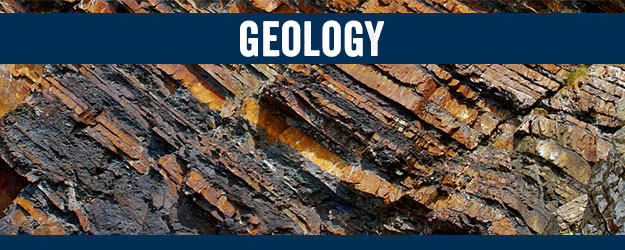

<div class="alert alert-block alert-info"><b></b></div>


# Executive Summary:
***
### Project Summary:

This project utilized web scraping and topic modeling to identify current trends in geologic research.  A function was developed that takes in a list of GitHub URL addresses and collects README text data and the repository's primary programming language. Topic modeling was performed using the LatentDirichletAllocation (LDA) class from the sklearn.decomposition library. Five trends were identified in the corpus over the course of two rounds of modeling, with trend association becoming clearer when common words were removed.  

***
### Background:

***Web scraping:***

Web scraping is the process of collecting structured web data in an automated fashion. In this project, we leveraged the speed of automated data collection to collect data from 500 GitHub repository README texts. To extract the necessary information, I developed a function based on a popular natural language processing (NLP) library known as Beautiful Soup. This tool allowed me to identify and extract information on websites and store them in a large file that made up the body (corpus) of the project.

***Topic modeling***

Topic modeling is an unsupervised learning technique that intends to analyze large volumes of text data by clustering the documents into groups. In the case of topic modeling, the text data does not have any labels attached to it. Instead, topic modeling tries to group the documents into clusters based on similar characteristics. A typical example of topic modeling is clustering a large body of text by clustering the documents into groups--in other words, cluster documents that have the same topic. It is challenging to evaluate the performance of topic modeling since there are no objectivly right answers. "Correctness" depends on the user's domain knowledge to find similar characteristics between one cluster's documents and assign it an appropriate label or topic.

***Latent Dirichlet Allocation (LDA)***

LDA is one of the two most common approaches used in topic modeling.  Using a specified set of “topics” (each topic represents a set of words), LDA maps all the documents to the topics so that those imaginary topics mostly capture the words in each document.

The LDA is based upon two general assumptions:
-	Documents which have similar words often share similar topics.
-	Documents which have groups of words frequently occurring together usually have the same topic.

These assumptions make sense because the documents that have the same topic. For instance, business topics will commonly have words such as "the economy," "profit," "the stock market," "loss," etc. The second assumption states that if these words frequently occur together in multiple documents, those documents may belong to the same category.

Mathematically, the above two assumptions can be represented as:
-	Documents are probability distributions over latent topics.
-	Topics are probability distributions over words.


***Remove Words with Ginsim Library***

The Gensim library is a powerful NLP library for Python. Gensim was primarily developed for topic modeling. However, it now supports a variety of other NLP tasks such as converting words to vectors (word2vec), document to vectors (doc2vec), finding text similarity, and text summarization. I will be using the Gensim library to remove stop words in my corpus due to its optimization for topic modeling.

***
### Process: (5 Steps)

1. Create list of words for corpus using feature extraction.
2. Apply LDA.
3. Use LDA to predict (n) topics.
4. Explore topics for correlations.
5. Repeat and tune model.

***
### Results:

***Topic modeling Round 1: Corpus with only stop words removed***
- In the first round of modeling, topics were hard to observe due to the large volume of common words shared between the documents. One Spanish language library (TypeScript) was removed from the corpus along with ~800 common words. These words were identified using domain knowledge and included common expressions and words associated with out of technological field terms (git, website, module, etc.)

***Topic modeling Round 2: Corpus with extra stop words removed***
- The second round of the model was more successful than the previous and was terminated when the list of the 20 most common words was content-related, and individual word frequencies were topic-specific. This second round of modeling produced five topics that could be generally described as follows:


Topic 0: Seismology   
Topic 1: Structural Geology   
Topic 2: Economic Geology   
Topic 3: Geomorphology   
Topic 4: Geochemistry    
 

***
### Next Steps:

***Validate Topics:***

- Go back and collect the title from the repository as well as the README text. Preform topic modeling on both and look for correlations.

***Expand Corpus:***

- Using the topics identified, scan more repositores and look to correlate results.




<div class="alert alert-block alert-info"><b></b></div>

# Project Goals:
***
1. Identify common trends in GitHub repository users who focus on geological research.
2. Produce a GitHub repository that contains a finalized notebook and README.
3. Create and present a 3-5 min presentation on findings using Google Slides.

<div class="alert alert-block alert-info"><b></b></div>

# Workflow:
***

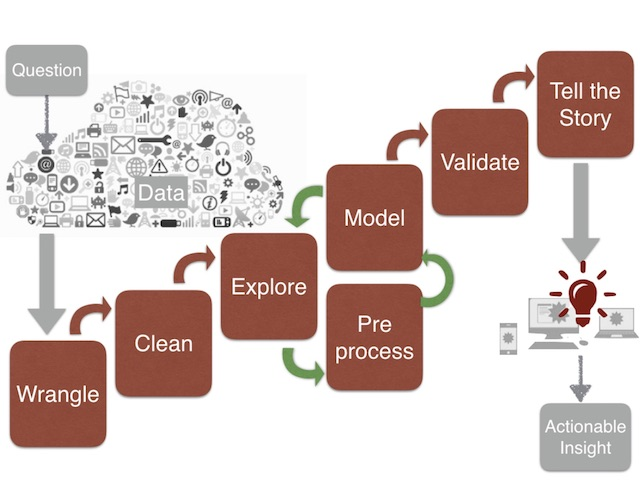

<div class="alert alert-block alert-info"><b></b></div>

# Imports:

In [1]:
import wrangle
import explore

<div class="alert alert-block alert-info"><b></b></div>

# Acquire:

<div class="alert alert-block alert-info"><b></b></div>

### Web-Scraping GitHub with Beautiful Soup
***

***1. Identify HTML target feature using Beautiful Soup***

`Repo README.md text` - soup.select('article', class_="markdown-body entry-content container-lg")[0].text

`Repo primary language` - soup.select('li.d-inline:nth-child(1) > a:nth-child(1)')[0].text

***2. Code extraction functions used to create corpus***

`def get_soup()`
This function takes in a URL, parses the HTML and returns a BeautifulSoup object

`def gethub_geology_urls()`
This function returns a list of URLs that can be read in the get_readme_articles() function

`def get_geo_results()`
This function scrapes and returns a list of repo URLs from search results

### Explanation:

Using the Beautiful Soup library, the README's of 507 GitHub repositories were scraped. I focused my search exclusively on repositories identified by the keyword 'Geology'. The results of this scrape were saved in a JSON file and were used as the research corpus.

<div class="alert alert-block alert-info"><b></b></div>

# Prepare:

<div class="alert alert-block alert-info"><b></b></div>

In [2]:
# def prep_data(df, column):
#     df['content_clean'] = df[column].apply(basic_clean)\
#                                     .apply(tokenize)\
#                                     .apply(lemmatize)\
#                                     .apply(remove_stopwords)\
#                                     .apply(remove_extra_words)

#     # add a column with a list of words
#     words = [re.sub(r'([^a-z0-9\s]|\s.\s)', '', doc).split() for doc in df.content_clean]

#     # column name will be words, and the column will contain lists of the words in each doc
#     df = pd.concat([df, pd.DataFrame({'words': words})], axis=1)

#     # add column with number of words in readme content
#     df['doc_length'] = [len(wordlist) for wordlist in df.words]
    
#     # Adds column with bigrams and trigrams
#     df['bigrams'] =  df['text_filtered'].apply(lambda row: list(nltk.bigrams(row.split(' '))))
#     df['trigrams'] =  df['text_filtered'].apply(lambda row: list(nltk.trigrams(row.split(' '))))
    
#     # Specify dataframe content
#     df = df[['language','content','content_clean','doc_length','words','bigrams','trigrams']]
#     return df


### Explanation:

`basic_clean( ):` This function changes the text to lowercase, removes special characters, encodes to ascii and recode to utf-8 to remove numbers from the text, and finally replaces anything that is not a letter, number, whitespace, or a single quote with an empty string.  

`tokenize( ):` This function takes in a string and returns that string broken up into a list of individual words.

`lemmatize( ):` This function takes in a string for and returns a string with words simplified to dictionary roots.

`remove_stopwords():` This function is a specialized cleaning tool from the Gensim library that cleans and parses text for topic modeling and removes more common words than the traditional NLTK library.

***
### Natural Language ToolKit (NLTK)

-NLTK library has 179 words in the stopword collection.

Note: All the words in the default library’s stopword list are in lower case, that means documents/sentences words also must be lower case. Otherwise, stopword not got removed from your data.

In [3]:
from nltk.corpus import stopwords
nltk_stopwords = set(stopwords.words('english'))
text = f"The first time I saw Catherine she was wearing a vivid crimson dress and was nervously " \
f"leafing through a magazine in my waiting room."
text_without_stopword = [word for word in text.split() if word.lower() not in nltk_stopwords]
print(f"Original Text : {text}")
print(f"Text without stopwords : {' '.join(text_without_stopword)}")
print(f"Total count of stopwords in NLTK is {len(nltk_stopwords)}")

Original Text : The first time I saw Catherine she was wearing a vivid crimson dress and was nervously leafing through a magazine in my waiting room.
Text without stopwords : first time saw Catherine wearing vivid crimson dress nervously leafing magazine waiting room.
Total count of stopwords in NLTK is 179


***
### Gensim Library

-Gensim has 337 words in their stopwords collection.

Note: 

In [4]:
from gensim.parsing.preprocessing import remove_stopwords
import gensim

gensim_stopwords = gensim.parsing.preprocessing.STOPWORDS

text = f"The first time I saw Catherine she was wearing a vivid crimson dress and was nervously " \
       f"leafing through a magazine in my waiting room."

print(f"Original Text : {text}")
print(f"Text without stopwords : {remove_stopwords(text.lower())}")
print(f"Total count of stopwords in Ginsim is {len(gensim_stopwords)}")

Original Text : The first time I saw Catherine she was wearing a vivid crimson dress and was nervously leafing through a magazine in my waiting room.
Text without stopwords : time saw catherine wearing vivid crimson dress nervously leafing magazine waiting room.
Total count of stopwords in Ginsim is 337


<div class="alert alert-block alert-info"><b></b></div>

# Data Exploration: (Topic Modeling)

1. Create list of words for corpus using feature extraction
2. Apply LDA
3. Use LDA to predict (n) topics
4. Explore topics for correlations
5. Repeat and tune model

<div class="alert alert-block alert-info"><b></b></div>

### Call in Clean Data Frame

In [5]:
df = wrangle.get_geo_results(cached=True)
df = wrangle.prep_data(df, 'content')
df.head()

,language,content,content_clean,doc_length,words,bigrams,trigrams
0,Python,Map Merger tool - tested using ArcMap 10.7\nWr...,map merger tool tested arcmap written ryan cro...,38,"[map, merger, tool, tested, arcmap, written, r...","[(map, merger), (merger, tool), (tool, tested)...","[(map, merger, tool), (merger, tool, tested), ..."
1,Jupyter Notebook,wellio.js\nJavaScript for converting well-log ...,welliojs javascript converting welllog standar...,1053,"[welliojs, javascript, converting, welllog, st...","[(welliojs, javascript), (javascript, converti...","[(welliojs, javascript, converting), (javascri..."
2,Python,geomodel-2-3dweb\n\nGenerates 3D web versions ...,geomodeldweb generates d web version geologica...,152,"[geomodeldweb, generatesweb, version, geologic...","[(geomodeldweb, generates), (generates, d), (d...","[(geomodeldweb, generates, d), (generates, d, ..."
3,JavaScript,GeoFeature\nGeological features of the Quanfoc...,geofeature geological feature quanfock hill de...,166,"[geofeature, geological, feature, quanfock, hi...","[(geofeature, geological), (geological, featur...","[(geofeature, geological, feature), (geologica..."
4,JavaScript,U.S. Geological Survey Best Practices\nThis re...,u geological survey best practice repository h...,13,"[u, geological, survey, best, practice, reposi...","[(u, geological), (geological, survey), (surve...","[(u, geological, survey), (geological, survey,..."


***
### Topic Modeling: Step One (Creating a list of Words using Feature Extraction)

*Before I can apply LDA, I needed to create a library of all the words in my data set. This is done with the help of a count vectorizer. The sklearn.feature_extraction.text module was used to create the document-term matrix. I only want to include words that are observed in less than 80% of the document and appear in at least two documents. I also remove all the stop words as they do not contribute to topic modeling.* 
 

In [6]:
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer(max_df=0.8, min_df=2, stop_words='english')
doc_term_matrix = count_vect.fit_transform(df['content_clean'].values.astype('U'))
doc_term_matrix

<507x5159 sparse matrix of type '<class 'numpy.int64'>'
	with 39279 stored elements in Compressed Sparse Row format>

*Each of 507 documents is represented as 5159 dimensional vector, which means that our corpus has 5159 words.*

***
### Topic Modeling: Step Two (Applying LDA)

*I next used the LatentDirichletAllocation class from the sklearn.decomposition library to perform LDA on the document-term matrix. The parameter n_components specifies the number of categories or topics that I want the text to be divided into. The parameter random_state (aka the seed) is set to 123 so that similar results are found each time. Let's verify it works by randomly selecting words from the vocabulary. I can use the get_feature_names() method and pass it the ID of the word that I want to verify.*

In [7]:
from sklearn.decomposition import LatentDirichletAllocation

LDA = LatentDirichletAllocation(n_components=5, random_state=42)
LDA.fit(doc_term_matrix)

LatentDirichletAllocation(n_components=5, random_state=42)

In [8]:
# 10 random words
import random

for i in range(10):
    random_id = random.randint(0,len(count_vect.get_feature_names()))
    print(count_vect.get_feature_names()[random_id])

spatially
manually
material
reid
hint
sensible
response
betbet
executables
topographic


***
### Topic Modeling: Step Three (Review Groups and Append to Data Frame)

*Using the components_ attribute from LDA, I used the argsort() function to sort the (n) number of words with the highest probability of being associated with each of the five topics.*

In [9]:
for i,topic in enumerate(LDA.components_):
    print(f'Top 10 words for topic #{i}:')
    print([count_vect.get_feature_names()[i] for i in topic.argsort()[-10:]])
    print('\n')

Top 10 words for topic #0:
['source', 'book', 'software', 'repository', 'license', 'project', 'report', 'data', 'enabled', 'file']


Top 10 words for topic #1:
['start', 'project', 'code', 'use', 'app', 'npm', 'build', 'test', 'run', 'file']


Top 10 words for topic #2:
['mesh', 'project', 'file', 'run', 'data', 'task', 'example', 'geomodeller', 'model', 'geology']


Top 10 words for topic #3:
['use', 'text', 'field', 'geologic', 'feature', 'geological', 'model', 'file', 'map', 'data']


Top 10 words for topic #4:
['pip', 'information', 'file', 'usgs', 'map', 'set', 'python', 'install', 'earthquake', 'data']




*As a final step, I will add a column to the original data frame to store the topic for the text. To do so, I will use LDA.transform() method and pass it to our document-term matrix. This method will assign the probability of all the topics to each document.*

In [10]:
topic_values = LDA.transform(doc_term_matrix)
topic_values.shape

(507, 5)

*The output (507, 5) alerts me to the fact that the documents have been sorted into five groups where each group corresponds to the probability value of a particular topic. Finally, I will add a new column for the topic in the data frame and assigns the topic value to each row in the column.*

In [11]:
df['topic'] = topic_values.argmax(axis=1)
df.head()

,language,content,content_clean,doc_length,words,bigrams,trigrams,topic
0,Python,Map Merger tool - tested using ArcMap 10.7\nWr...,map merger tool tested arcmap written ryan cro...,38,"[map, merger, tool, tested, arcmap, written, r...","[(map, merger), (merger, tool), (tool, tested)...","[(map, merger, tool), (merger, tool, tested), ...",0
1,Jupyter Notebook,wellio.js\nJavaScript for converting well-log ...,welliojs javascript converting welllog standar...,1053,"[welliojs, javascript, converting, welllog, st...","[(welliojs, javascript), (javascript, converti...","[(welliojs, javascript, converting), (javascri...",3
2,Python,geomodel-2-3dweb\n\nGenerates 3D web versions ...,geomodeldweb generates d web version geologica...,152,"[geomodeldweb, generatesweb, version, geologic...","[(geomodeldweb, generates), (generates, d), (d...","[(geomodeldweb, generates, d), (generates, d, ...",4
3,JavaScript,GeoFeature\nGeological features of the Quanfoc...,geofeature geological feature quanfock hill de...,166,"[geofeature, geological, feature, quanfock, hi...","[(geofeature, geological), (geological, featur...","[(geofeature, geological, feature), (geologica...",0
4,JavaScript,U.S. Geological Survey Best Practices\nThis re...,u geological survey best practice repository h...,13,"[u, geological, survey, best, practice, reposi...","[(u, geological), (geological, survey), (surve...","[(u, geological, survey), (geological, survey,...",0


***
## Topic Modeling: Step Four (Explore topics for correlations)

- Wordcount List

- Proportion Visualization

- Word clouds

### Call in df

In [12]:

df1 = wrangle.get_geo_results(cached=True)
df1 = wrangle.prep_data(df1, 'content')
df1 = explore.nlp_topic_modeling(df1, max_df = 0.8 , min_df = 2 , n_components = 5)
df1.head()

Top 5 words for topic #0:
['geological', 'usgs', 'text', 'report', 'set', 'project', 'earthquake', 'file', 'map', 'data']


Top 5 words for topic #1:
['example', 'code', 'geological', 'geology', 'version', 'python', 'run', 'model', 'data', 'file']


Top 5 words for topic #2:
['line', 'package', 'notebook', 'powerlaw', 'exercise', 'deposit', 'pip', 'conda', 'python', 'install']


Top 5 words for topic #3:
['code', 'app', 'project', 'npm', 'test', 'build', 'use', 'run', 'file', 'enabled']


Top 5 words for topic #4:
['earthquake', 'usgs', 'file', 'build', 'use', 'geological', 'project', 'app', 'android', 'license']




,language,content,content_clean,doc_length,words,bigrams,trigrams,topic
0,Python,Map Merger tool - tested using ArcMap 10.7\nWr...,map merger tool tested arcmap written ryan cro...,38,"[map, merger, tool, tested, arcmap, written, r...","[(map, merger), (merger, tool), (tool, tested)...","[(map, merger, tool), (merger, tool, tested), ...",4
1,Jupyter Notebook,wellio.js\nJavaScript for converting well-log ...,welliojs javascript converting welllog standar...,1053,"[welliojs, javascript, converting, welllog, st...","[(welliojs, javascript), (javascript, converti...","[(welliojs, javascript, converting), (javascri...",0
2,Python,geomodel-2-3dweb\n\nGenerates 3D web versions ...,geomodeldweb generates d web version geologica...,152,"[geomodeldweb, generatesweb, version, geologic...","[(geomodeldweb, generates), (generates, d), (d...","[(geomodeldweb, generates, d), (generates, d, ...",4
3,JavaScript,GeoFeature\nGeological features of the Quanfoc...,geofeature geological feature quanfock hill de...,166,"[geofeature, geological, feature, quanfock, hi...","[(geofeature, geological), (geological, featur...","[(geofeature, geological, feature), (geologica...",2
4,JavaScript,U.S. Geological Survey Best Practices\nThis re...,u geological survey best practice repository h...,13,"[u, geological, survey, best, practice, reposi...","[(u, geological), (geological, survey), (surve...","[(u, geological, survey), (geological, survey,...",0


In [13]:
# combine list of word counts into df for further exploration

# create a list of words for each language category and remove single letter words
t0_words,t1_words,t2_words,t3_words,t4_words = explore.create_lang_word_list(df1)

# get the count of words by category
t0_freq, t1_freq, t2_freq, t3_freq, t4_freq = explore.get_count_word_freq(t0_words,t1_words,t2_words,t3_words,t4_words)

# combine list of word counts into df for further exploration
word_counts1 = explore.create_df_word_counts(t0_freq, t1_freq, t2_freq, t3_freq, t4_freq)
word_counts1 = explore.word_counts_proportion(word_counts1)
word_counts1

,t0,t1,t2,t3,t4,all_words,prop_t0,prop_t1,prop_t2,prop_t3,prop_t4
&#9;,149,7,65,1,12,234,0.636752,0.029915,0.277778,0.004274,0.051282
&#9;dtm,0,0,4,0,0,4,0.000000,0.000000,1.000000,0.000000,0.000000
&#9;dtm&#9;,0,0,2,0,0,2,0.000000,0.000000,1.000000,0.000000,0.000000
&#9;expressed,1,0,0,0,0,1,1.000000,0.000000,0.000000,0.000000,0.000000
&#9;geological,1,0,0,0,0,1,1.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
zurich,1,0,0,0,0,1,1.000000,0.000000,0.000000,0.000000,0.000000
zusammenfassung,0,0,0,0,1,1,0.000000,0.000000,0.000000,0.000000,1.000000
zwischen,0,0,0,0,2,2,0.000000,0.000000,0.000000,0.000000,1.000000
zwrocic,0,0,1,0,0,1,0.000000,0.000000,1.000000,0.000000,0.000000


<Figure size 864x576 with 0 Axes>

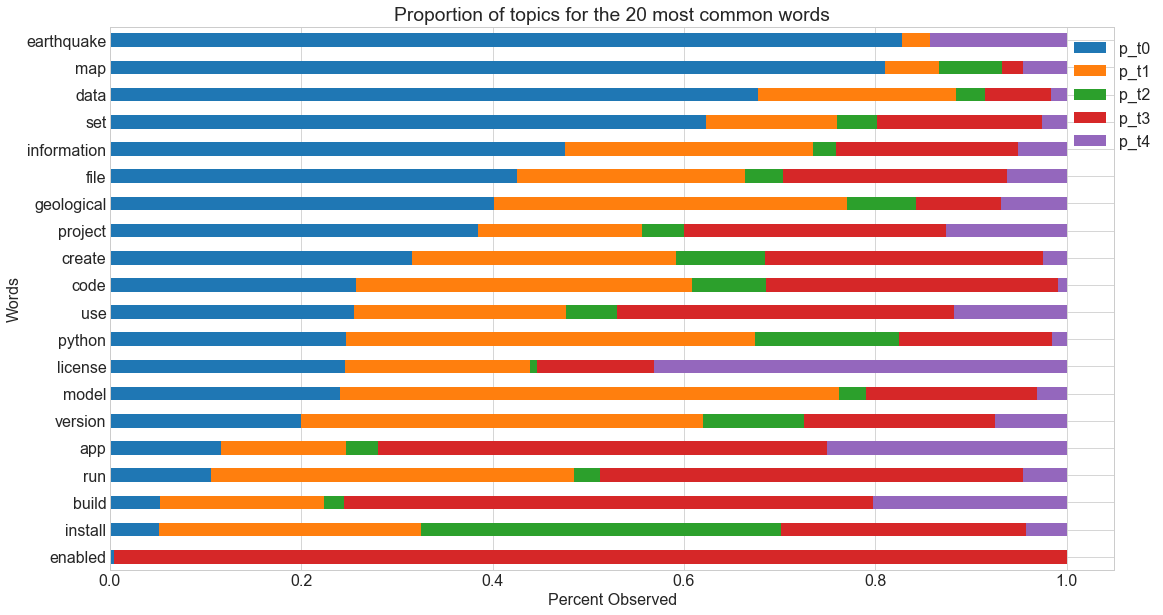

In [21]:
explore.proportion_visualization(word_counts1)

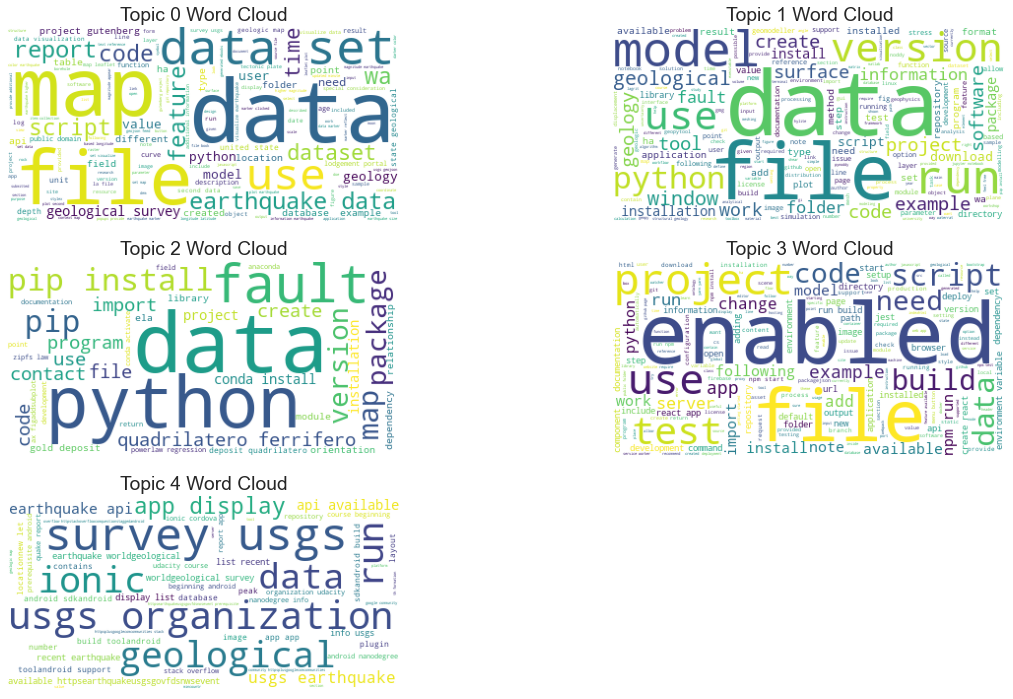

In [15]:
explore.plot_wordcloud(df1)

<div class="alert alert-block alert-info"><b></b></div>

### Takeaway:

`Some preliminary differences are visible, however common words block clear trends`

- To clean up corpus must remove common words (non-geologic terms).


- Remove repository in Spanish (TypeScript).


<div class="alert alert-block alert-info"><b></b></div>

### Topic Modeling: Step Five (Repeat and Tune Model)

- `Remove additional non-content specific common words (~800)`


- Run through the modeling process a second time to finalize topic modeling.

In [16]:
df2 = wrangle.get_geo_results(cached=True)
df2 = wrangle.prep_data_extra_words(df2, 'content')
df2.head()

,language,content,content_clean,doc_length,words,bigrams,trigrams
0,Python,Map Merger tool - tested using ArcMap 10.7\nWr...,merger tested arcmap written ryan crow usgs ai...,22,"[merger, tested, arcmap, written, ryan, crow, ...","[(merger, tested), (tested, arcmap), (arcmap, ...","[(merger, tested, arcmap), (tested, arcmap, wr..."
1,Jupyter Notebook,wellio.js\nJavaScript for converting well-log ...,welliojs converting welllog standard isn ' t p...,526,"[welliojs, converting, welllog, standard, isnt...","[(welliojs, converting), (converting, welllog)...","[(welliojs, converting, welllog), (converting,..."
2,Python,geomodel-2-3dweb\n\nGenerates 3D web versions ...,geomodeldweb generates d primarily geomodelpor...,89,"[geomodeldweb, generatesprimarily, geomodelpor...","[(geomodeldweb, generates), (generates, d), (d...","[(geomodeldweb, generates, d), (generates, d, ..."
3,JavaScript,GeoFeature\nGeological features of the Quanfoc...,geofeature quanfock hill demo httpsgeoffrowlan...,98,"[geofeature, quanfock, hill, demo, httpsgeoffr...","[(geofeature, quanfock), (quanfock, hill), (hi...","[(geofeature, quanfock, hill), (quanfock, hill..."
4,JavaScript,U.S. Geological Survey Best Practices\nThis re...,u best practice largely superseded usgs manage...,7,"[u, best, practice, largely, superseded, usgs,...","[(u, best), (best, practice), (practice, large...","[(u, best, practice), (best, practice, largely..."


### Apply Topic Modeling to New Corpus

In [17]:
df2 = explore.nlp_topic_modeling(df2, max_df = 0.8 , min_df = 2 , n_components = 5)
df2.head()

Top 5 words for topic #0:
['day', 'united', 'menu', 'depth', 'layer', 'log', 'state', 'magnitude', 'usgs', 'earthquake']


Top 5 words for topic #1:
['rank', 'analytical', 'stress', 'geomodeller', 'element', 'seismic', 'powerlaw', 'surface', 'fault', 'deposit']


Top 5 words for topic #2:
['symbol', 'consideration', 'date', 'layer', 'special', 'water', 'myenvname', 'ela', 'age', 'field']


Top 5 words for topic #3:
['borehole', 'profile', 'archive', 'digital', 'item', 'ontology', 'collection', 'ebooks', 'gitenberg', 'gutenberg']


Top 5 words for topic #4:
['iv', 'distributed', 'adding', 'deploy', 'edit', 'projection', 'cs', 'usgs', 'ionic', 'formation']




,language,content,content_clean,doc_length,words,bigrams,trigrams,topic
0,Python,Map Merger tool - tested using ArcMap 10.7\nWr...,merger tested arcmap written ryan crow usgs ai...,22,"[merger, tested, arcmap, written, ryan, crow, ...","[(merger, tested), (tested, arcmap), (arcmap, ...","[(merger, tested, arcmap), (tested, arcmap, wr...",0
1,Jupyter Notebook,wellio.js\nJavaScript for converting well-log ...,welliojs converting welllog standard isn ' t p...,526,"[welliojs, converting, welllog, standard, isnt...","[(welliojs, converting), (converting, welllog)...","[(welliojs, converting, welllog), (converting,...",0
2,Python,geomodel-2-3dweb\n\nGenerates 3D web versions ...,geomodeldweb generates d primarily geomodelpor...,89,"[geomodeldweb, generatesprimarily, geomodelpor...","[(geomodeldweb, generates), (generates, d), (d...","[(geomodeldweb, generates, d), (generates, d, ...",2
3,JavaScript,GeoFeature\nGeological features of the Quanfoc...,geofeature quanfock hill demo httpsgeoffrowlan...,98,"[geofeature, quanfock, hill, demo, httpsgeoffr...","[(geofeature, quanfock), (quanfock, hill), (hi...","[(geofeature, quanfock, hill), (quanfock, hill...",2
4,JavaScript,U.S. Geological Survey Best Practices\nThis re...,u best practice largely superseded usgs manage...,7,"[u, best, practice, largely, superseded, usgs,...","[(u, best), (best, practice), (practice, large...","[(u, best, practice), (best, practice, largely...",3


### Explore Topics 

In [18]:
# combine list of word counts into df for further exploration

# create a list of words for each language category and remove single letter words
t0_words,t1_words,t2_words,t3_words,t4_words = explore.create_lang_word_list(df2)

# get the count of words by category
t0_freq, t1_freq, t2_freq, t3_freq, t4_freq = explore.get_count_word_freq(t0_words,t1_words,t2_words,t3_words,t4_words)

# combine list of word counts into df for further exploration
word_counts2 = explore.create_df_word_counts(t0_freq, t1_freq, t2_freq, t3_freq, t4_freq)
word_counts2 = explore.word_counts_proportion(word_counts2)
word_counts2

,t0,t1,t2,t3,t4,all_words,prop_t0,prop_t1,prop_t2,prop_t3,prop_t4
aapgexamples,1,0,0,0,0,1,1.0,0.0,0.0,0.0,0.0
aardvark,0,0,0,2,0,2,0.0,0.0,0.0,1.0,0.0
aba,0,1,0,0,0,1,0.0,1.0,0.0,0.0,0.0
abandoned,1,0,0,0,0,1,1.0,0.0,0.0,0.0,0.0
abandonment,0,0,2,0,0,2,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
zurich,0,0,0,1,0,1,0.0,0.0,0.0,1.0,0.0
zusammenfassung,0,0,0,1,0,1,0.0,0.0,0.0,1.0,0.0
zwischen,0,0,0,2,0,2,0.0,0.0,0.0,1.0,0.0
zwrocic,0,0,0,1,0,1,0.0,0.0,0.0,1.0,0.0


<Figure size 864x576 with 0 Axes>

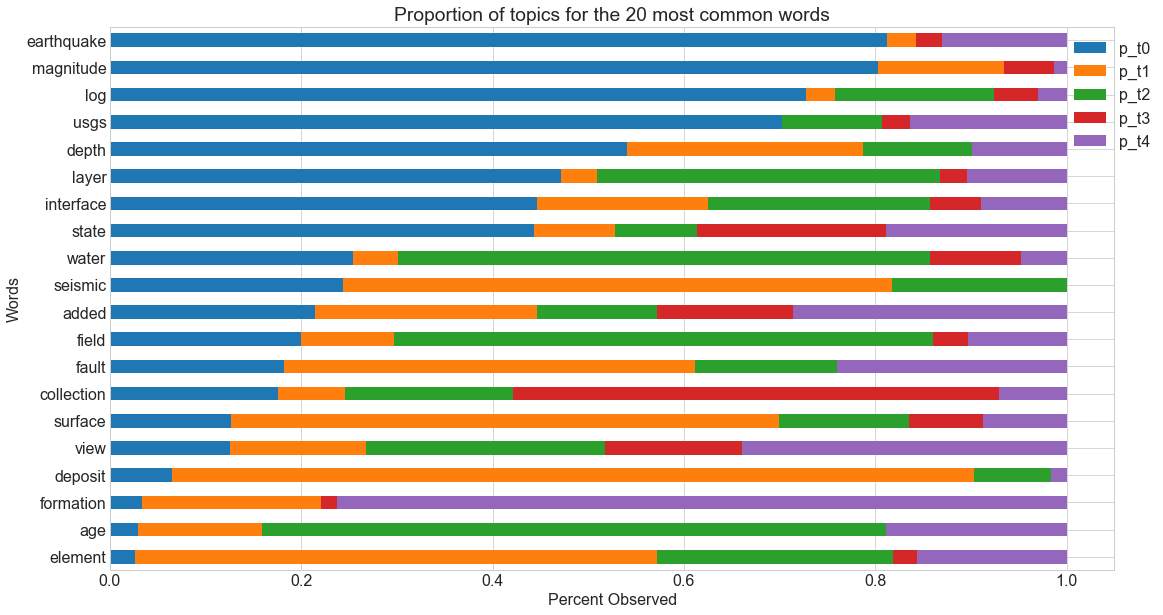

In [19]:
# visualize the % of the term in each language
explore.proportion_visualization(word_counts2)

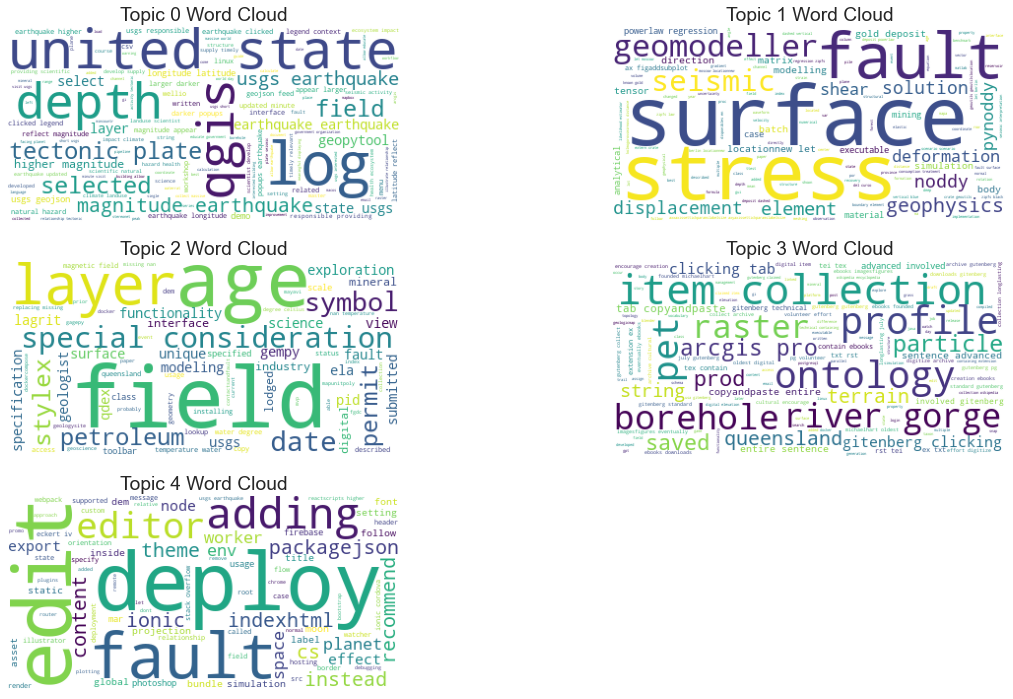

In [20]:
explore.plot_wordcloud(df2)

<div class="alert alert-block alert-info"><b></b></div>

### Takeaway:

- Clear trends visible
- 5 Topics can be generally described as follows:

Topic 0: Seismology   
Topic 1: Structural Geology   
Topic 2: Mining   
Topic 3: Geomorphology   
Topic 4: Geochemistry    

<div class="alert alert-block alert-info"><b></b></div>

# Results:

<div class="alert alert-block alert-info"><b></b></div>

***Topic modeling Round 1: Corpus with only stop words removed***
- In the first round of modeling, topics were hard to observe due to the large volume of common words shared between the documents. One Spanish language library (TypeScript) was removed from the corpus along with ~800 common words. These words were identified using domain knowledge and included common expressions and words associated with out of technological field terms (git, website, module, etc.)

***Topic modeling Round 2: Corpus with extra stop words removed***
- The second round of the model was more successful than the previous and was terminated when the list of the 20 most common words was content-related, and individual word frequencies were topic-specific. This second round of modeling produced five topics that could be generally described as follows:


Topic 0: Seismology   
Topic 1: Structural Geology   
Topic 2: Economic Geology   
Topic 3: Geomorphology   
Topic 4: Geochemistry   

<div class="alert alert-block alert-info"><b></b></div>

# Reflection Questions:

<div class="alert alert-block alert-info"><b></b></div>


### How did the project go? Did you meet your goal? Why or why not?

- This project ended differently than I thought it would. My goal was to see if it was possible to use NLP to discover topics inside a text body. However, I did not know that this was a sub-field of NLP known as topic modeling. After speaking to Ryan and doing a lot of research, I used a topic modeling library (LDA) to assist me with my goal. If I had known that this project would use a specific machine learning library to map the text into topics, I would have picked a cleaner data source (blog posts/research journals). I was bogged down in cleaning my corpus (removed 800 common words by hand), but I learned a lot about topic modeling in the process.   

### What are your next steps?

- The next steps are to scrape more README's and incorporate the repository title as a second corpus. I want to perform LDA on the main body of text and the titles to see to test how well I did at cleaning the data and implementing the machine learning library.   

### For each stage of the pipeline, where could you make improvements?

***Planning***
- I knew I wanted to keep working on an NPL project that I had started.  It was easy to transition that exploration into this project.   

***Acquire***
- I misdiagnosed an error in my acquire function that caused me many problems throughout this project. Initially, the function was designed to scrape repositories on the first 500 search pages, but instead it only scrapped the first search page 500 times. This setback cost me a lot of time. Wen I could make the fix a large enough corpus was returned to perform this project.

***Prepare***
- I struggled to get my function to remove stop words correctly. Finally, I installed the Gensim library to handle all of my stop words (you can apply Gensim to a body of text and not think about it) and created a function that looped through my list 0f 800 custom stop words that were used in the second round of modeling.

***Explore***
- In explore, I needed a function that would provide me with common words for my corpus so they could be removed. Most of my time in explore was spent identifying common words that needed to be removed before topic modeling would be effective.

***Model***
- Topic modeling and exploration were combined on this project. The first round of topic modeling produced muddy results and needed lots of time to explore identifying and removing common words before the second round of modeling providing generally identifiable topics.  

***Delivery***
- Delivery is the part of the pipeline that I am most comfortable with. I want to make sure that I have lots of time to prepare for delivery and lots of time to read up on Topic Modeling. Since it is an NLP technique that we did not learn in class, I want to make sure that I can explain how it works and why I chose to work with it before I present my findings.   

<div class="alert alert-block alert-info"><b></b></div>

# Next Steps:

<div class="alert alert-block alert-info"><b></b></div>

***Validate Topics:***

- Go back and collect the title from the repository as well as the README text.  Preform topic modeling on both and look for correlations.

***Expand Corpus:***

- Using the topics identified, scan more repositories and look to correlate results.